In [ ]:
# Diego Aguilar Torres - A01657884

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from math import sqrt
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(7)
tf.random.set_seed(7)

In [ ]:
csv_path = "train.csv"
train = pd.read_csv(csv_path, parse_dates=["date"])

# Filtro una serie
train = train.query("store == 1 and item == 1").copy()
train = train.sort_values("date")
print(train.head())
print(len(train))

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10
1826


In [ ]:
def make_supervised_windows(series: np.ndarray, window: int, lag: int):
  X, y = [], []
  for i in range(window, len(series)-lag):
    X.append(series[i-window:i+1])
    y.append(series[i+lag])
  return np.array(X), np.array(y)


window = 29
lag = 1
X, y = make_supervised_windows(train["sales"].values, window, lag)
print("X", X.shape, "y", y.shape)



X (1796, 30) y (1796,)


In [ ]:
# Division temporal y escalado
cut = int(len(X) * 0.8)
X_train, X_test = X[:cut], X[cut:]
y_train, y_test = y[:cut], y[cut:]

scaler_x = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_s = scaler_x.transform(X_train)
X_test_s = scaler_x.transform(X_test)
y_train_s = scaler_y.transform(y_train.reshape(-1, 1)).ravel()
y_test_s = scaler_y.transform(y_test.reshape(-1, 1)).ravel()

print("X_train_s", X_train_s.shape, "y_train_s", y_train_s.shape)

X_train_3d = X_train_s.reshape((len(X_train_s), window+1, 1))
X_test_3d = X_test_s.reshape((len(X_test_s), window+1, 1))

print("Train 3d:", X_train_3d.shape, "Test_3d:", X_test_3d.shape)


X_train_s (1436, 30) y_train_s (1436,)
Train 3d: (1436, 30, 1) Test_3d: (360, 30, 1)


In [ ]:
# CNN 1D
model_cnn = Sequential([
    Conv1D(filters=32, kernel_size=3, activation="relu", input_shape=(window+1, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(1)
]
)

model_cnn.compile(optimizer="adam", loss="mse")
model_cnn.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,529 (56.75 KB)

 Trainable params: 14,529 (56.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn = model_cnn.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6885
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5420
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5134
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4981
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4843
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4757
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4675
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4583
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4479
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4383
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4297
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4217
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4110
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3988
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3899
Epoch 16/50
45/45 ━

In [ ]:
# Predictions
pred_cnn_s = model_cnn.predict(X_test_3d).ravel()
pred_cnn = scaler_y.inverse_transform(pred_cnn_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_cnn)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE: 7.0498957957689825


In [ ]:
# LSTM
model_lstm = Sequential([
    LSTM(32, activation="tanh", input_shape=(window+1, 1)),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = model_lstm.fit(X_train_3d, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.7298
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.6156
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.6113
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6087
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6068
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6054
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6041
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6030
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6021
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6011
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6002
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5993
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5985
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.5977
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5969
Epoc

In [ ]:
pred_lstm_s = model_lstm.predict(X_test_3d).ravel()
pred_lstm = scaler_y.inverse_transform(pred_lstm_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
RMSE: 5.119193160141532


In [ ]:
# CNN + LSTM
subseq = 5
assert(window+1) % subseq == 0, "window must be divisible by subseq"
steps_per_subseq = (window+1) // subseq

Xtr4 = X_train_3d.reshape((len(X_train_3d), subseq, steps_per_subseq, 1))
Xtest4 = X_test_3d.reshape((len(X_test_3d), subseq, steps_per_subseq, 1))

model_cnn_lstm = Sequential([
    TimeDistributed(Conv1D(filters=32, kernel_size=3, activation="relu"),
                    input_shape=(subseq, steps_per_subseq, 1)),
    TimeDistributed(MaxPooling1D(2)),
    TimeDistributed(Flatten()),
    LSTM(32, activation="tanh"),
    Dense(1)
])

model_cnn_lstm.compile(optimizer="adam", loss="mse")
model_cnn_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 5, 4, 32)       │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 2, 32)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 64)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,577 (49.13 KB)

 Trainable params: 12,577 (49.13 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_cnn_lstm = model_cnn_lstm.fit(Xtr4, y_train_s, epochs=50, batch_size=32, verbose=1)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.7183
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5945
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5752
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5652
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5569
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5497
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5433
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5374
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5320
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5272
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5229
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5191
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5157
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5126
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5096
Epoch 16/50
45/45 ━

In [ ]:
pred_cnn_lstm_s = model_cnn_lstm.predict(Xtest4).ravel()
pred_cnn_lstm = scaler_y.inverse_transform(pred_cnn_lstm_s.reshape(-1, 1)).ravel()
print("RMSE:", sqrt(mean_squared_error(y_test, pred_cnn_lstm)))

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
RMSE: 5.436253722736262


In [ ]:
# Plotting results
import matplotlib.pyplot as plt

rmse_cnn = sqrt(mean_squared_error(y_test, pred_cnn))
rmse_lstm = sqrt(mean_squared_error(y_test, pred_lstm))
rmse_cnn_lstm = sqrt(mean_squared_error(y_test, pred_cnn_lstm))

print("Summary RMSE")
print("CNN:", rmse_cnn)
print("LSTM:", rmse_lstm)
print("CNN + LSTM:", rmse_cnn_lstm)

Summary RMSE
CNN: 7.0498957957689825
LSTM: 5.119193160141532
CNN + LSTM: 5.436253722736262


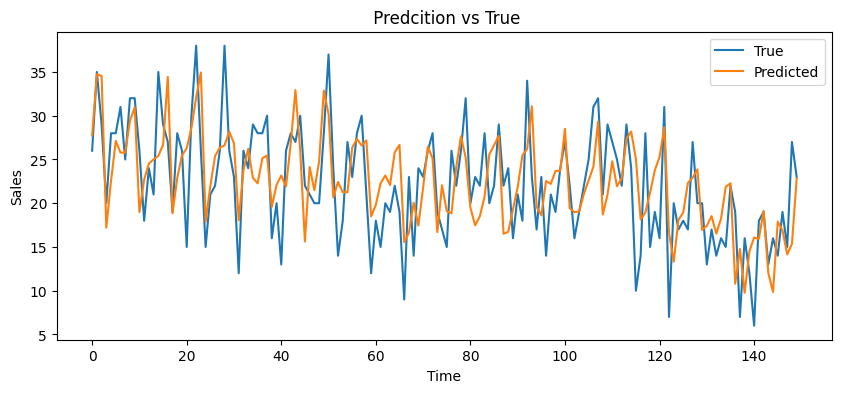

In [ ]:
y_true = y_test
y_pred = pred_cnn_lstm
k = 150 if len(y_true) > 150 else len(y_true)

plt.figure(figsize=(10, 4))
plt.plot(y_true[-k:], label="True")
plt.plot(y_pred[-k:], label="Predicted")
plt.title(" Predcition vs True")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.show()